# Sparse GP regression with Gibbs

In [1]:
# !pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
# !pip install numpy==1.23.5

## Imports

In [2]:
import sys
import os
import time
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
import numpy as np

plt.style.use('Solarize_Light2')

# os.environ['JAX_ENABLE_X64'] = 'True'
import jax
from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.sparsegp import SparseGPModel

# confirm precision setting
x = jrnd.uniform(jrnd.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype # --> dtype('float64')

dtype('float64')

## utils

In [3]:
def plot_cov(cov, title, iter='', show_negative=True, figsize=(4, 12)):    
    # transform jax array to numpy array to allow mutation
    cov_np = np.array(cov)  

    cmap = plt.cm.plasma

    # replace negativ values with nan to make them visible in the plot
    if show_negative:
        cmap.set_bad((.5, 0, 0, 1))
        for c in np.argwhere(cov_np < 0):
            cov_np[c[0], c[1]] = np.nan
    
    fig, ax = plt.subplots(figsize=figsize) 
    image = plt.imshow(cov_np, cmap=cmap) 
    # creating new axes on the right side of (ax) for the colorbar
    # this new axis has the same hight as the original axis
    divider = make_axes_locatable(ax) 
    colorbar_axes = divider.append_axes("right", 
                                        size="10%", 
                                        pad=0.1)
    plt.colorbar(image, 
                 cax=colorbar_axes, 
                 ticks=None if show_negative else [np.min(cov_np), np.mean(cov_np), np.max(cov_np)])

    # colorbar_axes.ticklabel_format(style='plain')
    ax.set_title(title)
    plt.savefig(f'results/cov_{title}_iter{iter}.png')
    plt.savefig(f'results/cov_{title}.png')
    # plt.show()
    plt.close()
    

## simulate data
Simulate some data from a known GP so we can look at the inference of the hyperparameters):

seed: 3662
x: mean 7.5, std 4.373646976927594


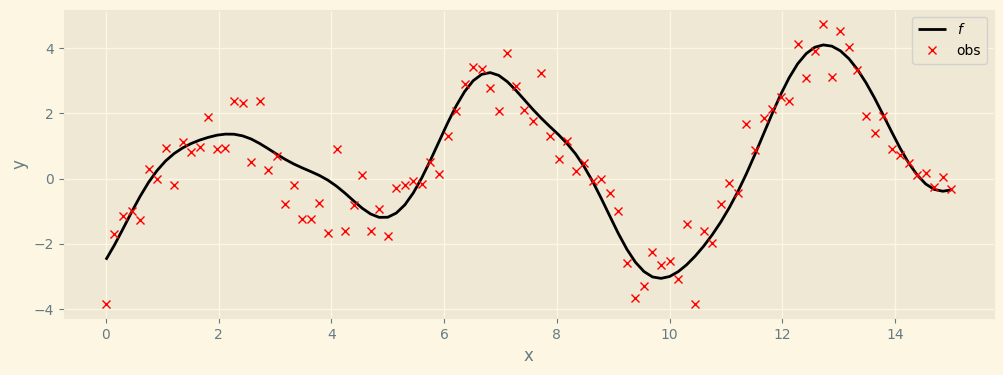

In [4]:
random_random_seed = np.random.randint(0, 10000 + 1)
print('seed:', random_random_seed)
key = jrnd.PRNGKey(5609)  # 1106, 5368, 8928

lengthscale_ = 1.0 #0.2
output_scale_ = 5.0
obs_noise_ = 0.7
n = 100
x = jnp.linspace(0, 15, n)[:, jnp.newaxis]  # NOTE: Rossie seem to use x-domain of [-1, 1]

x_mean = jnp.mean(x)
x_std = jnp.std(x)
print(f'x: mean {jnp.round(x_mean, decimals=10)}, std {x_std}')

kernel = jk.RBF()
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x) + 1e-6*jnp.eye(n)
# plot_cov(K, 'true cov')

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))
f_true = jnp.dot(L, z) + jnp.zeros_like(z)  # NOTE: True GP had mean=1

key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'$f$')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([0., 1.])
plt.legend()

# WIP implementing

Set up the GP models, either with $\mathbf{f}$ sampled explicitly, or with $\mathbf{f}$ margnalized out (theobvious choice for a Gaussian likelihood, but sampling is shown for pedagogical reasons):

## Prior & init. model

In [5]:
# prior over covariance hyperparameters, likelihood, and inducing inputs.

num_inducing_points = 20

priors = dict(
    kernel=dict(  # Rossi uses lognormal priors over kernel parameters. 
        # NOTE: Rossi uses a seperate lengthscale per feature.
        #   - do they mean locations with features? Or is this about multiple inputs?

        # lengthscale = dx.Transformed( 
        #     dx.Normal(loc=0, scale=.5), # NOTE: Adjusted to be closer to real value 
        #     tfb.Exp()), 
        # lengthscale = dx.Normal(loc=lengthscale_, scale=0.3),  # HACk: almost true cov prior
        lengthscale = dx.Deterministic(loc=lengthscale_),  # HACK: true cov

        # variance = dx.Transformed( 
        #     dx.Normal(loc=1.5, scale=.5),  # NOTE: Adjusted to be closer to real value 
        #     tfb.Exp())), # log Normal as in Rossi
        # variance = dx.Normal(loc=output_scale_, scale=1.0)),  # HACk: almost true cov prior
        variance = dx.Deterministic(loc=output_scale_)),  # HACK: true cov

    likelihood=dict(  # actually not modeled in Rossi
        # obs_noise = dx.Transformed(
        #    dx.Normal(loc=0., scale=1.), 
        #    tfb.Exp())
        obs_noise = dx.Deterministic(loc=obs_noise_)  # HACK: Using true obs_noise without updating it. 
        ),

    inducing_inputs_Z=dict( 
    # NOTE: Defining distribution over Z directly results in an error
        # the __init__ tries to sample from each distribution in the prior.
        mean=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_mean),
        scale=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_std*.8)))

gp_sparse = SparseGPModel(
    x, y, 
    cov_fn=jk.RBF(), priors=priors, 
    num_inducing_points=num_inducing_points,
    f_true=f_true)  
# NOTE Defaults to likelihood=Gaussian()

## Gibbs (for-loop)

### first gibbs_state

In [6]:
%%script false --no-raise-error  # hack to skip execution of a cell

# playground, for testing only
gibbs_state = gp_sparse.init_fn(
    key=key, 
    num_particles = sampling_parameters['num_particles'])

def plot_prior():
    # plot true function, inducing points, estimated function
    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5)
    plt.plot(x, gibbs_state.position['f'], label=r'prior $f$', color='lightblue')
    plt.plot(
        gibbs_state.position['Z'], 
        gibbs_state.position['u'], 
        'x', 
        label='inducing points', 
        color='red',
        alpha=1.)
    plt.xlabel('x & Z')
    plt.ylabel('y & u')
    # plt.xlim([0., 1.])
    plt.legend()
    plt.savefig(f'results/prior.png')
    plt.show()

plot_prior()

# plot covariance matrices
def _plot_covs():
    for t in gibbs_state.position['dev'].keys():
        c = gibbs_state.position['dev'][t]
        print(f'{t}: {c.shape}')
        if t == 'cov_gp':
            plot_cov(c, t, show_negative=False, figsize=(8, 12))
            plot_cov(c, t + '\nred = negative values', 
                    show_negative=True, 
                    figsize=(8, 12))
        else:
            plot_cov(c, t, show_negative=False)

# _plot_covs()

### utils

In [7]:
# utils: pretty print gibbs state, IPython progress bar

def update_progress(progress, extra=''):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, extra)



### training loop

In [8]:
%%time
%%script false --no-raise-error  # hack to skip execution of a cell

gibbs_state_hist = [gibbs_state]
for i in range(1, sampling_parameters['num_mcmc_steps']):
    t_start = time.time()

    key, key_gibbs = jrnd.split(key)  # TODO: Should I reuse the same key every iteration instead of splitting a new one?
    gibbs_state_, _ = gp_sparse.gibbs_fn(key_gibbs, gibbs_state_hist[-1], sampling_parameters)
    gibbs_state_hist.append(gibbs_state_)
    
    # dumb current gibbst state history
    if i % 100 == 0:
        file = open(f'results/gibbs_state_hist.pkl', 'wb')
        pickle.dump(gibbs_state_hist, file)
        file.close()

    # update progressbar
    if i % 10 == 0:
        update_progress(i / sampling_parameters["num_mcmc_steps"])

    # show and save plots
    if (i % 50 == 0) and (i > 0):
        plot_posterior(gibbs_state_hist, num_of_samples=1_000, iter=i)
        plot_inducing_variables(gibbs_state_hist)
        plot_training_history(gibbs_state_hist)
        # plot_cov(gibbs_state_hist[-1].position['dev']['cov_gp'], title='gp', iter=i)

    if i % 10 == 0:
        print(f'    iter {i}, duration: {jnp.round(time.time() - t_start, decimals = 3)} sec')

update_progress(1)
plot_posterior(
    gibbs_state_hist,   
    num_of_samples=1_000, 
    iter=sampling_parameters['num_mcmc_steps'])
plot_inducing_variables(gibbs_state_hist)
plot_training_history(gibbs_state_hist)

CPU times: user 1.48 ms, sys: 4.48 ms, total: 5.97 ms
Wall time: 7.75 ms


## Gibbs (Jax)

In [9]:
%%script false --no-raise-error  # hack to skip execution of a cell
%%time

# randomize the models inital state
random_random_seed = np.random.randint(0, 10000 + 1)
print('random random seed:', random_random_seed)
key = jrnd.PRNGKey(random_random_seed)

# define parameters for inference
sampling_parameters = dict(
    num_burn=0,  # gibbs
    num_samples=20_000  # gibbs | num_mcmc_steps
    )
    
# run inference
with jax.disable_jit(disable=False):  # TODO: Add alarming print when disabled
    key, key_inference = jrnd.split(key)

    initial_state, gibbs_states = gp_sparse.inference(
        key_inference, 
        mode='gibbs', 
        sampling_parameters=sampling_parameters)

 # save all data to file
if False:
    data = {
        'x': x,
        'f_true': f_true,
        'initial_state': initial_state,
        'gibbs_states': gibbs_states
    }
    file = open(f'results/gibbs_states.pkl', 'wb')
    pickle.dump(data, file)
    file.close()

### Analyze results

In [11]:
%%script false --no-raise-error
print('\nGibbs-state keys:')
# print all keys and len/shape of corresponding data
for k in gibbs_states.position.keys():
    try:
        print('    ', k, 
              gibbs_states.position[k]
              if len(gibbs_states.position[k].shape) == 0 
              else gibbs_states.position[k].shape, 
              end='\n')
    except:
        print('    ', k, len(gibbs_states.position[k]), end='\n')
print()

print('\ninital values')
print('lengthscale:', initial_state.position['lengthscale'])
print('variance', initial_state.position['variance'])

In [12]:
%%script false --no-raise-error

def plot_prior(initial_state):
    """
    Plot true function and prior
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)
    
    plt.title(f'true function, noisy data, and prior')
    plt.legend()
    plt.show()

def plot_posterior(gibbs_state_hist, initial_state, num_of_samples=100):
    """
    Plot true function and posterior samples
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    plt.plot(
        gibbs_state_hist.position['Z'][-1],
        # jnp.mean(gibbs_state_hist.position['Z'][-num_of_samples: ], axis=0),
        gibbs_state_hist.position['u'][-1], 
        # jnp.mean(gibbs_state_hist.position['u'][-num_of_samples: ], axis=0),
        'x', 
        label='posterior\ninducing points\nlast sample', 
        color='red',
        alpha=1.0,
        zorder=2)

    # plt.plot(
    #     gibbs_state_hist.position['Z'][-num_of_samples: ],
    #     gibbs_state_hist.position['u'][-num_of_samples: ], 
    #     'x', 
    #     # label='posterior\ninducing points\nall samples', 
    #     color='red',
    #     alpha=0.1,
    #     zorder=0)

    plt.plot(
        # gibbs_state_hist.position['Z'][-1],
        jnp.mean(gibbs_state_hist.position['Z'][-num_of_samples: ], axis=0),
        #gibbs_state_hist.position['u'][-1], 
        jnp.mean(gibbs_state_hist.position['u'][-num_of_samples: ], axis=0),
        'x', 
        label='mean posterior\ninducing points', 
        color='orange',
        alpha=1.0,
        zorder=2)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)

    # get last `num_of_states` gibbs states
    f_samples = gibbs_state_hist.position['f'][-1*num_of_samples:]

    # plot each sample
    '''for i in range(f_samples.shape[0]):  # negativ indexing to select last elements
        plt.plot(x, f_samples[i], 
                color='orange',
                alpha=0.1)'''
        
    # plot average and confidence intervals
    f_mean = jnp.mean(f_samples, axis=0)
    f_hdi_lower = jnp.percentile(f_samples, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_samples, q=97.5, axis=0)
    ax = plt.gca()
    ax.plot(x, f_mean, label='mean f~GP', color='green', lw=1.5, zorder=1)
    ax.fill_between(
        x.flatten(), f_hdi_lower, f_hdi_upper, 
        alpha=0.5, color='lightgreen', lw=0)
    # ax.set_ylim(
    #     jnp.min(f_true) - 1, 
    #     jnp.max(f_true) + 1)
    
    plt.title(f'last {f_samples.shape[0]} posterior samples')
    plt.legend()
    # plt.savefig(f'results/posterior_iter{iter}.png')
    # plt.savefig(f'results/posterior.png')
    plt.show()
    # plt.close()
    
def plot_cov_param_trajectory(lengthscale=None, variance=None, title=''):
    # Plot training history

    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    cmap = plt.colormaps.get_cmap('Set1')

    if lengthscale is not None:
        ax.plot(
            lengthscale, 
            label='lengthscale', 
            color=cmap(0), alpha=1,
            zorder=1)
        ax.axhline(
            lengthscale_, 
            linestyle='--', 
            label=f'true lengthscale ({lengthscale_})',
            color=cmap(0), alpha=1,
            zorder=2)
        ax.set_ylabel('lengthscale', color=cmap(0))
        lengthscale_mean = jnp.mean(lengthscale)
        lengthscale_hdi_lower = jnp.percentile(lengthscale, q=2.5, axis=0)
        lengthscale_hdi_upper = jnp.percentile(lengthscale, q=97.5, axis=0)
        # ax.set_ylim(lengthscale_hdi_lower*1.5, lengthscale_hdi_upper*1.5)
        # if lengthscale.shape[0] >= 200:
        #     ax.set_ylim(
        #         jnp.min(lengthscale[400:])*1.5, 
        #         jnp.max(lengthscale[400:])*1.5)

    if variance is not None:
        ax2.plot(
            variance, 
            label='variance', 
            color=cmap(1), alpha=1,
            zorder=3)
        ax2.axhline(output_scale_, 
                    linestyle='--', 
                    label=f'true variance ({output_scale_})',
                    color=cmap(1), alpha=1,
                    zorder=4)
        ax2.set_ylabel('variance', color=cmap(1))

    # create shared legend for both axis
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax.set_xlabel('Gibbs iterations')
    plt.title(title)
    plt.show()
    # plt.close()

def plot_param_trajectory(
        param_gibbs_hist:dict, 
        title:str='', 
        color_idxs:list=[0, 1]):
    # Plot training history

    fig, ax = plt.subplots(figsize=(12, 4))    
    cmap = plt.colormaps.get_cmap('Set1')

    for i, (param, data) in enumerate(param_gibbs_hist.items()):

        if i == 1:
            ax = ax.twinx()
        ax.plot(data, label=param, color=cmap(color_idxs[i]))
        # ax.axhline(lengthscale_, linestyle='--', color=cmap(0), 
        #         label=f'true lengthscale ({lengthscale_})')
        ax.set_ylabel(param, color=cmap(color_idxs[i]))
        ax.legend()

    # create shared legend for both axis
    # lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax.set_xlabel('iterations')
    plt.title(title)
    plt.show()
    # plt.close()

def plot_u_trajectories(gibbs_state_hist, gibbs_key:str='u'):
    # plot u trajectories
    u_samples = gibbs_state_hist.position[gibbs_key]

    iter_idx = range(len(u_samples))
    color = plt.cm.hsv(np.linspace(0, 1, u_samples.shape[1]))

    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    ax.set_facecolor('grey')
    for i in range(u_samples.shape[1]):
        plt.plot(iter_idx, u_samples[:, i], alpha=0.7, color=color[i], lw=1)
    plt.xlabel('Gibbs iterations')
    plt.title(f'{gibbs_key} samples')
    # plt.savefig(f'results/train_hist_{gibbs_key}.png')
    plt.show()
    # plt.close()

def plot_inducing_variables(gibbs_state_hist):
    plot_u_trajectories(gibbs_state_hist, gibbs_key='u')
    plot_u_trajectories(gibbs_state_hist, gibbs_key='Z')

def plot_param_histogram(
    param_samples:dict,
    bins:int = 20,
    title:str='', 
    color_idxs:list=[0, 1]):

    fig, ax = plt.subplots(
        ncols=len(param_samples), 
        figsize=(12, 4), 
        squeeze=False)
    cmap = plt.colormaps.get_cmap('Set1')

    for i, (param, data) in enumerate(param_samples.items()):
        ax[0, i].hist(
            data,
            density=True,
            bins=bins, 
            color=cmap(color_idxs[i]),)
        ax[0, i].set_title(param)

    plt.suptitle(title)
    plt.show()


plot_prior(initial_state)
plot_posterior(
    gibbs_states,
    initial_state,
    num_of_samples=sampling_parameters['num_samples'])
plot_param_histogram(
    param_samples = {
        'lengthscale': gibbs_states.position['lengthscale'],
        'variance': gibbs_states.position['variance'],
        'obs_noise': gibbs_states.position['obs_noise']
        },
    color_idxs=[0, 1, 2]
)
plot_inducing_variables(gibbs_states)
plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'],
    variance = gibbs_states.position['variance'])
plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'])
plot_cov_param_trajectory(
    variance = gibbs_states.position['variance'])

plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'][:100],
    variance = gibbs_states.position['variance'][:100],
    title='first 100 iterations')
plot_param_trajectory(
    param_gibbs_hist = {
        'lengthscale': gibbs_states.position['lengthscale'][200:],
        'variance': gibbs_states.position['variance'][200:],
        },
    title='after 200 iter',
    color_idxs=[0, 1]
    )
plot_param_trajectory(
    param_gibbs_hist = {'obs_noise': gibbs_states.position['obs_noise']},
    color_idxs=[2]
    )

## SMC-in-Gibbs

In [13]:
%%time

# randomize the models inital state
random_random_seed = np.random.randint(0, 10000 + 1)
print('random random seed:', random_random_seed)
key = jrnd.PRNGKey(random_random_seed)

# define parameters for inference
sampling_parameters = dict(
    #num_burn=0,  # gibbs
    #num_samples=20_000  # gibbs | num_mcmc_steps

    num_particles=1_0,  # SMC
    num_mcmc_steps=2_0  # SMC
    )
    
# run inference
with jax.disable_jit(disable=False):  # TODO: Add alarming print when disabled
    key, key_inference = jrnd.split(key)

    # initial_state, gibbs_states = gp_sparse.inference(
    #     key_inference, 
    #     mode='gibbs-in-smc', 
    #     sampling_parameters=sampling_parameters)` 

    initial_particles, particles, num_iter, marginal_likelihood = gp_sparse.inference(
        key_inference, 
        mode='gibbs-in-smc', 
        sampling_parameters=sampling_parameters)

    # unpack results for easy access
    particles = particles.particles

random random seed: 1954
CPU times: user 14 s, sys: 2.06 s, total: 16 s
Wall time: 10 s


### Analyzing results

In [14]:
for para, val in sampling_parameters.items():
    print(para, ':', val)

num_particles : 10
num_mcmc_steps : 20


In [15]:
for k in particles.keys():
    print(k, ':', particles[k].shape)

Z : (10, 20)
f : (10, 100)
lengthscale : (10,)
mean : (10, 20)
obs_noise : (10,)
scale : (10, 20)
u : (10, 20)
variance : (10,)


In [ ]:
# # Plot predictive f
# key, predict_f_key = jrnd.split(key)

# f_samples = gp_sparse.predict_f(
#     key=predict_f_key, 
#     x_pred=jnp.linspace(0, 15, 80))
# print(f_samples.shape)

---

# hidden
Run inference:

In [ ]:
%%time

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

Plot posteriors of hyperparameters for both models:

In [ ]:
trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))


num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                       sharex='col', sharey='col', figsize=(12, 6))
axes = np.expand_dims(axes, axis=0)  # quick fix as I removed a whole row of plots

for m, particles in enumerate([lgp_particles]):
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = particles.particles[var]
        # There are some outliers that skew the axis
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd_filtered, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');

And plot the posterior predictive of $\mathbf{f}$:

AttributeError: 'SparseGPModel' object has no attribute 'kernel'

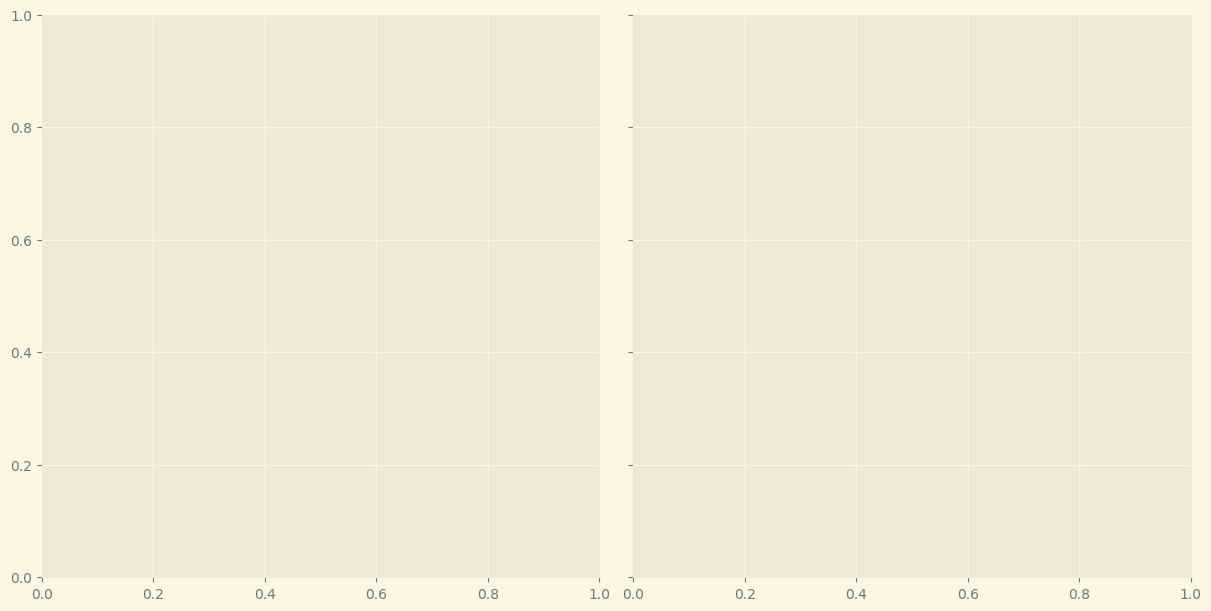

In [18]:


x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)
axes = np.expand_dims(axes, axis=0)  # quick fix as I removed a whole row of plots

for j, gp in enumerate([gp_sparse]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-4., 5.])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Latent GP', rotation=0, ha='right');